## Library

In [1]:
cd /workdir/github

/workdir/github


In [2]:
import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 

import numpy as np
import os
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
torch.set_num_threads(1)
device = torch.device(f"cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
from os import listdir
from os.path import isfile, join

In [4]:
from speaker_verification.transforms import Audio_Transforms
from speaker_verification.transforms import Image_Transforms
from speaker_verification.models import Model
from speaker_verification.dataset import SpeakingFacesDataset
from speaker_verification.dataset import TrainDataset
from speaker_verification.dataset import ValidDataset
from speaker_verification.sampler import ProtoSampler
from speaker_verification.loss import PrototypicalLoss
from speaker_verification.train import train_model

## General Pipeline

In [4]:
# dataset
annotations_file = "/workdir/github/annotations_file_short_joint_cleaned.csv"
path2datasets = "/workdir/sf_pv"
dataset_dir = f"{path2datasets}/data_v2"
data_type = ['rgb']

# model
library = "timm"
model_name = "resnet34"
pretrained_weights=True
fine_tune=True
embedding_size=128
pool=None

# transform
audio_T = None
image_T = None

# sampler
n_batch=10
n_ways=2
n_support=1
n_query=1

# loss
dist_type='squared_euclidean'

# train
num_epochs=1
save_dir='/workdir/results'
exp_name='chern'
wandb=None

In [5]:
if 'wav' in data_type:
    # audio transform params
    sample_rate=16000
    sample_duration=2 # seconds
    n_fft=512 # from Korean code
    win_length=400
    hop_length=160
    window_fn=torch.hamming_window
    n_mels=40

    audio_T = Audio_Transforms(sample_rate=sample_rate,
                                sample_duration=sample_duration, # seconds
                                n_fft=n_fft, # from Korean code
                                win_length=win_length,
                                hop_length=hop_length,
                                window_fn=torch.hamming_window,
                                n_mels=n_mels,
                                model_name=model_name,
                                library=library)
    audio_T = audio_T.transform

if 'rgb' in data_type or 'thr' in data_type:
    image_T = Image_Transforms(model_name=model_name,
                               library=library)

    image_T = image_T.transform 

In [ ]:
train_dataset = SpeakingFacesDataset(ANNOTATIONS_FILE,DATASET_DIR,'train',
                                    image_transform=image_T, 
                                    audio_transform=audio_T,
                                    data_type=data_type)

In [10]:
ANNOTATIONS_FILE = "/workdir/github/annotations_file_short_VX2_cleaned.csv"
DATASET_DIR = "/workdir/VoxCeleb2/dev"

In [11]:
df_all = pd.read_csv(ANNOTATIONS_FILE)

In [14]:
df_all['train_type'] = np.full(len(df_all), 'train')

In [15]:
df_all

,source,utterance,data_type,session_id,person_id,train_type
0,00001.jpg,1.0,rgb,21Uxsk56VDQ,12,train
1,00001.jpg,10.0,rgb,21Uxsk56VDQ,12,train
2,00001.jpg,11.0,rgb,21Uxsk56VDQ,12,train
3,00001.jpg,12.0,rgb,21Uxsk56VDQ,12,train
4,00001.jpg,13.0,rgb,21Uxsk56VDQ,12,train
...,...,...,...,...,...,...
2299149,00023.wav,23.0,wav,u7VNkYraCw0,9272,train
2299150,00024.wav,24.0,wav,u7VNkYraCw0,9272,train
2299151,00025.wav,25.0,wav,u7VNkYraCw0,9272,train
2299152,00026.wav,26.0,wav,u7VNkYraCw0,9272,train


In [17]:
df_all[df_all['data_type'] == 'thr']

,source,utterance,data_type,session_id,person_id,train_type
5169,00001.jpg,1.0,thr,96Z18I2UKAE,29,train
5170,00001.jpg,10.0,thr,96Z18I2UKAE,29,train
5171,00001.jpg,11.0,thr,96Z18I2UKAE,29,train
5172,00001.jpg,12.0,thr,96Z18I2UKAE,29,train
5173,00001.jpg,13.0,thr,96Z18I2UKAE,29,train
...,...,...,...,...,...,...
2298773,00001.jpg,496.0,thr,zodUH_1KhJM,9269,train
2298774,00001.jpg,497.0,thr,zodUH_1KhJM,9269,train
2298775,00001.jpg,498.0,thr,zodUH_1KhJM,9269,train
2298776,00001.jpg,499.0,thr,zodUH_1KhJM,9269,train


In [ ]:
class SpeakingFacesDataset(Dataset):
    def __init__(self, annotations_file, 
                       dataset_dir, 
                       train_type, 
                       data_type, # ['wav','rgb','thr']
                       dataset_type, # VX2 or SF
                       image_transform=None, 
                       audio_transform=None
                ):

        super(SpeakingFacesDataset, self).__init__()

        self.dataset_dir = f'{dataset_dir}'
        self.train_type = train_type
        self.data_type = data_type
        self.dataset_type = dataset_type
        self.df_all = pd.read_csv(annotations_file)
        self.df_all = self.df_all[self.df_all['train_type'] == self.train_type]
        self.df_wav = self.df_all[self.df_all['data_type'] == 'wav']
        self.labels = self.df_wav["person_id"].values

        self.image_transform = image_transform
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.df_wav)

    def __getitem__(self, index):

        sample = self._get_data(index)
        return sample

    def _get_data(self, index):

        label = self._get_sample_label(index)

        path2wav, path2rgb, path2thr = self._get_sample_path(index)

        data = {}
        
        if "wav" in self.data_type:
            data["wav"], sample_rate = torchaudio.load(path2wav)
            if self.audio_transform:
                data["wav"] = self.audio_transform(data["wav"], sample_rate)

        if "rgb" in self.data_type:
            data["rgb"] = io.imread(path2rgb)
            if self.image_transform:
                data["rgb"] = self.image_transform(data["rgb"])
            
        if "thr" in self.data_type:
            data["thr"] = io.imread(path2thr)
            if self.image_transform:
                data["thr"] = self.image_transform(data["thr"])

        data = dict(sorted(data.items()))
        sample = (*list(data.values()), label)
        
        return sample
    
    def _get_sample_path(self, index):

        utterance = self.df_wav.iloc[index,1]
        session_id = self.df_wav.iloc[index,3]
        person_id = self.df_wav.iloc[index,4]

        df_sample = self.df_all[self.df_all.person_id == person_id]
        df_sample = df_sample[df_sample.utterance == utterance]
        df_sample = df_sample[df_sample.session_id == session_id]

        if self.dataset_type == "VX2":
            path2dataset = "VoxCeleb2/dev"
            n_zeros = 5 - len(str(person_id))
            person_id_real = 'id'+ '0'*n_zeros + str(person_id)
            
        elif self.dataset_type == "SF":
            path2dataset = "sf_pv/data_v2"
            person_id_real = f'sub_{str(person_id)}'

        path2wav = os.path.join(self.dataset_dir,f'sub_{person_id}',
                        f'{session_id}', 'wav', 
                        df_sample.iloc[0, 0])

        path2rgb = os.path.join(self.dataset_dir,f'sub_{person_id}',
                            f'{session_id}', 'rgb', f'{utterance}',
                            df_sample.iloc[1, 0])

        path2thr = os.path.join(self.dataset_dir,f'sub_{person_id}',
                                    f'{session_id}', 'thr', f'{utterance}',
                                    df_sample.iloc[2, 0])

        return path2wav, path2rgb, path2thr

    def _get_sample_label(self, index):
        # return torch.tensor(self.df_wav.iloc[index, 4])
        return torch.tensor(self.labels[index])

## Joint train dataset

In [6]:
from skimage import io

In [7]:
class Dataset_train(Dataset):
    def __init__(self, annotations_file, 
                       dataset_dir, 
                       train_type,
                       data_type, 
                       dataset_type = "joint",
                       image_transform=None, 
                       audio_transform=None):

        """ 
        Input parameters:
            dataset_dir: path to the directory where all datasets are located.
            annotations_file: annotation file joined VX2 + SF.
            dataset_type: can be either "SF", "VX2" or "joint".
        """

        self.dataset_dir = f'{dataset_dir}'
        self.train_type = train_type
        self.data_type = data_type
        self.dataset_type = dataset_type

        self.df_all = pd.read_csv(annotations_file)
        if dataset_type != "joint":
            self.df_all = self.df_all[self.df_all["dataset"] == dataset_type]

        self.df_all = self.df_all[self.df_all['train_type'] == self.train_type]
        self.df_wav = self.df_all[self.df_all['data_type'] == 'wav']

        self.df_wav.reset_index(inplace=True)
        self.df_wav = self.df_wav.drop(["index"], axis=1)

        self.labels = self.df_wav["new_ids"].values

        self.image_transform = image_transform
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.df_wav)

    def __getitem__(self, index):

        sample = self._get_data(index)
        return sample

    def _get_data(self, index):

        label = self._get_sample_label(index)

        path2wav, path2rgb, path2thr = self._get_sample_path(index)

        data = {}
        
        if "wav" in self.data_type:
            if path2wav:
                data["wav"], sample_rate = torchaudio.load(path2wav)
            if self.audio_transform:
                data["wav"] = self.audio_transform(data["wav"], sample_rate)

        if "rgb" in self.data_type:
            if path2rgb:
                data["rgb"] = io.imread(path2rgb)
            if self.image_transform:
                data["rgb"] = self.image_transform(data["rgb"])
            
        if "thr" in self.data_type:
            if path2thr:
                data["thr"] = io.imread(path2thr)
            if self.image_transform:
                data["thr"] = self.image_transform(data["thr"])

        data = dict(sorted(data.items()))
        sample = (*list(data.values()), label)
        
        return sample

    def _get_sample_path(self, index):

        dataset_type = self.df_wav.loc[index, "dataset"]
        person_id = self.df_wav.loc[index, "person_id"]
        session_id = self.df_wav.loc[index, "session_id"]
        utterance = int(self.df_wav.loc[index, "utterance"])

        df_sample = self.df_all[self.df_all.dataset == dataset_type]
        df_sample = df_sample[df_sample.person_id == person_id]
        df_sample = df_sample[df_sample.session_id == session_id]
        df_sample = df_sample[df_sample.utterance == utterance]

        if self.dataset_type == "VX2":
            path2dataset = "VoxCeleb2/dev"
            n_zeros = 5 - len(str(person_id))
            person_id_real = 'id'+ '0'*n_zeros + str(person_id)
            
        elif self.dataset_type == "SF":
            path2dataset = "sf_pv/data_v2"
            person_id_real = f'sub_{str(person_id)}'

        if 'wav' in df_sample['data_type'].values:
            path2wav = os.path.join(self.dataset_dir, person_id_real,
                            f'{session_id}', 'wav', 
                            df_sample[df_sample['data_type'] == 'wav'].iloc[0, 0])
        else:
            path2wav = None

        if 'rgb' in df_sample['data_type'].values:
            path2rgb = os.path.join(self.dataset_dir, person_id_real,
                            f'{session_id}', 'rgb', f'{utterance}',
                            df_sample[df_sample['data_type'] == 'rgb'].iloc[0, 0])
        else:
            path2rgb = None

        if 'thr' in df_sample['data_type'].values:
            path2thr = os.path.join(self.dataset_dir, person_id_real,
                            f'{session_id}', 'thr', f'{utterance}',
                            df_sample[df_sample['data_type'] == 'thr'].iloc[0, 0])
        else:
            path2thr = None

        return path2wav, path2rgb, path2thr

    def _get_sample_label(self, index):
        return torch.tensor(self.df_wav.loc[index,"new_ids"])

In [9]:
# dataset
annotations_file = "/workdir/github/annotations_file_short_joint_cleaned.csv"
dataset_dir = "/workdir/VoxCeleb2/dev"
data_type = ['rgb']

# model
library = "timm"
model_name = "resnet34"
pretrained_weights=True
fine_tune=True
embedding_size=128
pool=None

# transform
audio_T = None
image_T = None

# sampler
n_batch=10
n_ways=2
n_support=1
n_query=1

# loss
dist_type='squared_euclidean'

# train
num_epochs=1
save_dir='/workdir/results'
exp_name='chern'
wandb=None

In [10]:
if 'wav' in data_type:
    # audio transform params
    sample_rate=16000
    sample_duration=2 # seconds
    n_fft=512 # from Korean code
    win_length=400
    hop_length=160
    window_fn=torch.hamming_window
    n_mels=40

    audio_T = Audio_Transforms(sample_rate=sample_rate,
                                sample_duration=sample_duration, # seconds
                                n_fft=n_fft, # from Korean code
                                win_length=win_length,
                                hop_length=hop_length,
                                window_fn=torch.hamming_window,
                                n_mels=n_mels,
                                model_name=model_name,
                                library=library)
    audio_T = audio_T.transform

if 'rgb' in data_type or 'thr' in data_type:
    image_T = Image_Transforms(model_name=model_name,
                               library=library)

    image_T = image_T.transform 

In [11]:
train_dataset = Dataset_train(annotations_file,
                              dataset_dir,
                              train_type='train',
                              data_type=data_type,
                              dataset_type = "VX2",
                              image_transform=image_T, 
                              audio_transform=audio_T
                            )

In [12]:
data, label = train_dataset[0]

In [13]:
data.shape

torch.Size([3, 128, 128])

Text(0.5, 1.0, 'RGB: Label = 143')

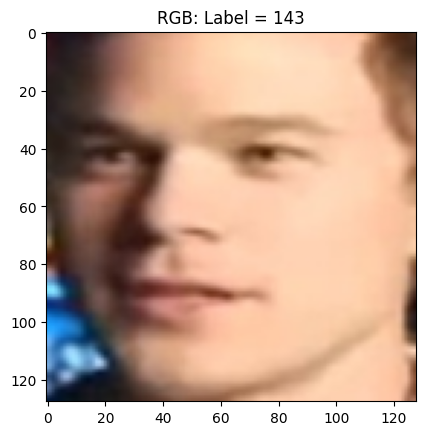

In [14]:
plt.imshow(data.permute(1,2,0))
plt.title(f"RGB: Label = {label}")

In [55]:
df_all = pd.read_csv(annotations_file)

In [57]:
dataset_type = 'VX2'
person_id = 12
session_id = '21Uxsk56VDQ'
utterance = 1

df_sample = df_all[df_all.dataset == dataset_type]
df_sample = df_sample[df_sample.person_id == person_id]
df_sample = df_sample[df_sample.session_id == session_id]
df_sample = df_sample[df_sample.utterance == utterance]

In [67]:
len(df_all[df_all['dataset'] == "VX2"]['person_id'].unique())

5994

In [60]:
df_sample['data_type'].values

array(['rgb', 'wav'], dtype=object)

In [61]:
'rgb' in df_sample['data_type'].values

True

## valid dataset

In [59]:
from os import listdir
from os.path import isfile, join

In [80]:
class ValidDataset(Dataset):
    def __init__(self, path_to_dataset, 
                       path_to_valid_list, 
                       data_type,
                       dataset_type,
                       image_transform=None, 
                       audio_transform=None
                ):

        super(ValidDataset, self).__init__()

        self.path_to_dataset = path_to_dataset
        self.data_type = data_type
        self.dataset_type = dataset_type
        self.path_to_valid_list = path_to_valid_list

        with open(self.path_to_valid_list) as f:
            self.pairs_list = f.read().splitlines()
        
        self.image_transform = image_transform
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.pairs_list)

    def __getitem__(self, index):

        id1_path, id2_path, label =  self._get_pair(index)

        id1 = self._get_data(id1_path)
        id2 = self._get_data(id2_path)

        return id1, id2, label

    def _get_pair(self, index):
        data_info = self.pairs_list[index].split()

        pairs_label = int(data_info[0]) # same or different: 0 or 1
        id1_path = data_info[1] # here is a path to the wav
        id2_path = data_info[2]

        return id1_path, id2_path, pairs_label

    def _get_data(self, id_path):

        label = self._get_sample_label(id_path)

        path2wav, path2rgb, path2thr = self._get_sample_path(id_path)

        data = {}
        
        if "wav" in self.data_type:
            data["wav"], sample_rate = torchaudio.load(path2wav)
            if self.audio_transform:
                data["wav"] = self.audio_transform(data["wav"], sample_rate)

        if "rgb" in self.data_type:
            data["rgb"] = io.imread(path2rgb)
            if self.image_transform:
                data["rgb"] = self.image_transform(data["rgb"])
            
        if "thr" in self.data_type:
            data["thr"] = io.imread(path2thr)
            if self.image_transform:
                data["thr"] = self.image_transform(data["thr"])

        data = dict(sorted(data.items()))
        sample = (*list(data.values()), label)
        
        return sample
    
    def _get_sample_path(self, id_path):
        
        if self.dataset_type == "SF":
            path = "/".join(self.path_to_dataset.split("/")[:-1]) # path to sf_pv

            path2wav = f"{path}/{id_path}"
            path2rgb = f"{path}/" + "/".join(id_path.split("/")[:-2]) + "/" + "rgb" + "/" + id_path.split("/")[-1].split(".")[0] + "/1.jpg"
            path2thr = f"{path}/" + "/".join(id_path.split("/")[:-2]) + "/" + "thr" + "/" + id_path.split("/")[-1].split(".")[0] + "/1.jpg"
        elif self.dataset_type == "VX2":
            path = self.path_to_dataset

            path2wav = f"{path}/{id_path}"
            wav_id = str(int(path2wav.split("/")[-1].split('.')[0]))

            path2rgb = f"{path}/" + "/".join(id_path.split("/")[:-2]) + "/" + "rgb" + "/"  + str(int(id_path.split("/")[-1].split(".")[0])) 
            onlyfiles = [f for f in listdir(path2rgb) if isfile(join(path2rgb, f)) and 'jpg' in f]
            path2rgb = path2rgb + "/" + onlyfiles[0]

            path2thr = f"{path}/" + "/".join(id_path.split("/")[:-2]) + "/" + "thr" + "/" + str(int(id_path.split("/")[-1].split(".")[0]))
            onlyfiles = [f for f in listdir(path2thr) if isfile(join(path2thr, f)) and 'jpg' in f]
            path2thr = path2thr + "/" + onlyfiles[0]

        return path2wav, path2rgb, path2thr

    def _get_sample_label(self, id_path):
        
        if self.dataset_type == "SF":
            label = int(id_path.split("/")[2].split("_")[-1])
        elif self.dataset_type == "VX2":
            label = int(id_path.split('/')[0][2:])

        return label

In [62]:
# dataset
annotations_file = "/workdir/github/annotations_file_short_joint_cleaned.csv"
path2datasets = "/workdir/sf_pv"
dataset_dir = "/workdir/VoxCeleb2/dev"
data_type = ['rgb']

# model
library = "timm"
model_name = "resnet34"
pretrained_weights=True
fine_tune=True
embedding_size=128
pool=None

# transform
audio_T = None
image_T = None

# sampler
n_batch=10
n_ways=2
n_support=1
n_query=1

# loss
dist_type='squared_euclidean'

# train
num_epochs=1
save_dir='/workdir/results'
exp_name='chern'
wandb=None

In [63]:
if 'wav' in data_type:
    # audio transform params
    sample_rate=16000
    sample_duration=2 # seconds
    n_fft=512 # from Korean code
    win_length=400
    hop_length=160
    window_fn=torch.hamming_window
    n_mels=40

    audio_T = Audio_Transforms(sample_rate=sample_rate,
                                sample_duration=sample_duration, # seconds
                                n_fft=n_fft, # from Korean code
                                win_length=win_length,
                                hop_length=hop_length,
                                window_fn=torch.hamming_window,
                                n_mels=n_mels,
                                model_name=model_name,
                                library=library)
    audio_T = audio_T.transform

if 'rgb' in data_type or 'thr' in data_type:
    image_T = Image_Transforms(model_name=model_name,
                               library=library)

    image_T = image_T.transform 

In [64]:
# path_to_valid_list = '/workdir/VoxCeleb1/metadata/test_list_vc_v2.txt'
# path_to_dataset = '/workdir/VoxCeleb1/test'
path_to_valid_list = '/workdir/sf_pv/metadata/valid_list_v2.txt'
path_to_dataset = '/workdir/sf_pv'

In [65]:
valid_dataset = ValidDataset(path_to_dataset, 
                       path_to_valid_list, 
                       data_type=['rgb'],
                       dataset_type='SF',
                       train_type='valid',
                       image_transform=image_T, 
                       audio_transform=audio_T)

valid_dataloader = DataLoader(dataset=valid_dataset,
                            batch_size=64,
                            shuffle=True)

In [66]:
id1, id2, label = valid_dataset[0]

In [67]:
from tqdm.notebook import tqdm

In [68]:
for batch in tqdm(valid_dataloader):
    id1, id2, label = batch

  0%|          | 0/594 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [168]:
data, label = id1

Text(0.5, 1.0, 'RGB: Label = 101')

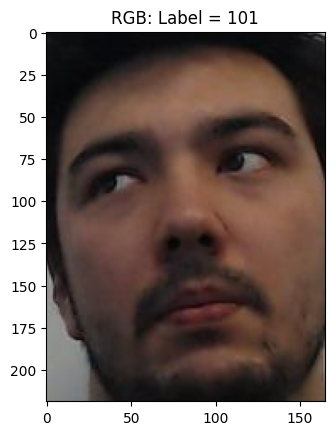

In [163]:
plt.imshow(data)
plt.title(f"RGB: Label = {label}")

## check datasets

In [5]:
# dataset
# annotations_file = "/workdir/github/annotations_file_short_SF.csv"

dataset_type = 'VX2'

if dataset_type == 'VX2':
    annotations_file = "/workdir/github/annotations_file_short_joint_cleaned.csv"
    path_to_train_dataset = f"/workdir/VoxCeleb2/dev"
    path_to_valid_dataset = "/workdir/VoxCeleb1/test"
    path_to_valid_list = "/workdir/VoxCeleb1/metadata/test_list_vc_v2.txt"
    
data_type = ['rgb']

# model
library = "timm"
model_name = "resnet34"
pretrained_weights=True
fine_tune=True
embedding_size=128
pool=None

# transform
audio_T = None
image_T = None

# sampler
n_batch=160
n_ways=60
n_support=1
n_query=1

# loss
dist_type='squared_euclidean'

# train
num_epochs=1
save_dir='/workdir/results'
exp_name='chern'
wandb=None

In [6]:
if 'wav' in data_type:
    # audio transform params
    sample_rate=16000
    sample_duration=2 # seconds
    n_fft=512 # from Korean code
    win_length=400
    hop_length=160
    window_fn=torch.hamming_window
    n_mels=40

    audio_T = Audio_Transforms(sample_rate=sample_rate,
                                sample_duration=sample_duration, # seconds
                                n_fft=n_fft, # from Korean code
                                win_length=win_length,
                                hop_length=hop_length,
                                window_fn=torch.hamming_window,
                                n_mels=n_mels,
                                model_name=model_name,
                                library=library)
    audio_T = audio_T.transform

if 'rgb' in data_type or 'thr' in data_type:
    image_T = Image_Transforms(model_name=model_name,
                               library=library)

    image_T = image_T.transform         

model = Model(library=library, 
            pretrained_weights=pretrained_weights, 
            fine_tune=fine_tune, 
            embedding_size=embedding_size,
            model_name = model_name,
            pool=pool,
            data_type=data_type)

model = model.to(device)         

rgb data type
timm model is used.


In [7]:
# Dataset
train_dataset = TrainDataset(annotations_file=annotations_file,
                            path_to_train_dataset=path_to_train_dataset,
                            data_type=data_type, 
                            dataset_type=dataset_type,
                            train_type = 'train',
                            image_transform=image_T, 
                            audio_transform=audio_T)

In [8]:
data, label = train_dataset[0]

In [9]:
train_sampler = ProtoSampler(train_dataset.labels,
                                n_batch,
                                n_ways, # n_way
                                n_support, # n_shots
                                n_query)

train_dataloader = DataLoader(dataset=train_dataset, 
                            batch_sampler=train_sampler)

In [10]:
valid_dataset = ValidDataset(path_to_valid_dataset, 
                                path_to_valid_list, 
                                data_type=data_type,
                                dataset_type='VX2',
                                image_transform=image_T, 
                                audio_transform=audio_T)

valid_dataloader = DataLoader(dataset=valid_dataset,
                            batch_size=64)

In [11]:
data1, data2, label = valid_dataset[0]

In [12]:
for batch in valid_dataloader:
    data1, data2, label = batch
    break

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.95)

In [14]:
criterion = PrototypicalLoss(dist_type=dist_type)
criterion = criterion.to(device)

In [15]:
model = train_model(model=model,
                    train_dataloader=train_dataloader, 
                    valid_dataloader=valid_dataloader,
                    train_sampler=train_sampler,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    device=device,
                    num_epochs=num_epochs,
                    save_dir=save_dir,
                    exp_name=exp_name,
                    data_type=data_type,
                    wandb=None)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train (epoch = 0):   0%|          | 0/160 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [01:00<?, ?it/s]


KeyboardInterrupt: 